In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('AER_credit_card_data.csv')

In [3]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [4]:
df.card = df.card.apply(lambda x: 1 if x == "yes" else 0)
df.owner = df.owner.apply(lambda x: 1 if x == "yes" else 0)
df.selfemp = df.selfemp.apply(lambda x: 1 if x == "yes" else 0)

# Question 1

In [5]:
from sklearn.metrics import roc_auc_score

In [6]:
numerical = df.dtypes[(df.dtypes=='float') | (df.dtypes=='int64')].index

In [35]:
for c in numerical:
    score = roc_auc_score(df.card,df[c])
    if score > 0.5 :
        print(c,roc_auc_score(df.card,df[c]).round(3))
    else:
        print(c,roc_auc_score(df.card,-df[c]).round(3))

card 1.0
reports 0.716
age 0.504
income 0.584
share 0.988
expenditure 0.989
owner 0.587
selfemp 0.51
dependents 0.518
months 0.521
majorcards 0.541
active 0.591


Answer : share

# Question 2

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp","card"]

In [10]:
df_full_train,df_test = train_test_split(df[columns],test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

y_test = df_test.card.values
y_val = df_val.card.values
y_train = df_train.card.values

del df_test['card']
del df_val['card']
del df_train['card']

df_test.reset_index(inplace=True)
df_train.reset_index(inplace=True)
df_val.reset_index(inplace=True)
df_full_train.reset_index(inplace=True)

In [11]:
from sklearn.feature_extraction import DictVectorizer

In [12]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

train_val = df_val.to_dict(orient='records')
X_val = dv.fit_transform(train_val)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [14]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:,1]
card_decision = (y_pred>=0.5).astype('int')

In [15]:
roc_auc_score(y_val,card_decision)

0.9739783600107306

Answer: 0.995

# Question 3

In [16]:
threshold = np.linspace(0,1,101)

In [17]:
t=0.5

In [18]:
pred_pos = (y_pred>=t)
pred_neg = (y_pred<t)
act_pos = (y_val>=t)
act_neg = (y_val<t)

tp = (pred_pos & act_pos).sum()
tn = (pred_neg & act_neg).sum()
fp = (pred_pos & act_neg).sum()
fn = (pred_neg & act_pos).sum()
tp,tn,fp,fn

(204, 52, 1, 7)

In [19]:
recall_l = []
precision_l=[]
for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    recall_l.append(recall)
    precision_l.append(precision)

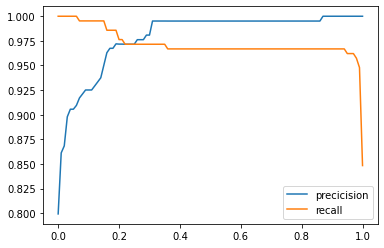

In [20]:
plt.plot(threshold,precision_l,label='precicision')
plt.plot(threshold,recall_l,label='recall')
plt.legend()

Answer : 0.3

# Question 4

In [21]:
f1_l = []
for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * precision * recall/ (precision + recall)
    f1_l.append(f1)

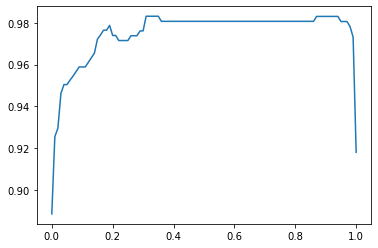

In [22]:
plt.plot(threshold,f1_l)

In [23]:
np.max(np.array(f1_l))

0.9832134292565947

Answer:0.6

# Question 5

In [24]:
columns = ['index', 'reports', 'age', 'income', 'share', 'expenditure',
       'dependents', 'months', 'majorcards', 'active', 'owner', 'selfemp']

In [25]:
def train(df,y_train,C=1):
    dv = DictVectorizer(sparse=False)
    train_dict = df_train[columns].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv,model

In [27]:
def predict(df,dv,model):
    dicts = df[columns].to_dict(orient='records')
    X = dv.fit_transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [29]:
from sklearn.model_selection import KFold

In [30]:
kfold = KFold(n_splits=10,shuffle=True,random_state=1)

In [32]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df = df_full_train.copy()
    df_train = df.iloc[train_idx]
    df_val = df.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [33]:
np.std(scores)

0.0044805973661280795

Answer : 0.003

# Question 6

In [34]:
for c in [0.01, 0.1, 1, 10]:
    scores=[]
    for train_idx, val_idx in kfold.split(df_full_train):
        df = df_full_train.copy()
        df_train = df.iloc[train_idx]
        df_val = df.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train,c)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (c, np.mean(scores), np.std(scores)))

C=0.01 0.991 +- 0.010
C=0.1 0.994 +- 0.006
C=1 0.996 +- 0.004
C=10 0.996 +- 0.004


Answer : 1